In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #To supress warnings
import glob 
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential    # import Sequential from tensorflow.keras
from tensorflow.keras.layers import Dense, LSTM  # import Dense from tensorflow.keras.layers
from numpy.random import seed     # seed helps you to fix the randomness in the neural network.  
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import early_stopping, log_evaluation
from collections import Counter
from sklearn.decomposition import PCA

/kaggle/input/amex-default-prediction-feather/00_slim_data.ipynb
/kaggle/input/amex-default-prediction-feather/test.feather
/kaggle/input/amex-default-prediction-feather/train.feather
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
# Amount of data we want to load into the Model...
DATA_ROWS = None
# Dataframe, the amount of rows and cols to visualize...
NROWS = 50
NCOLS = 15
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_columns', NCOLS) 
pd.set_option('display.max_rows', NROWS)

In [3]:
%%time
train_df = pd.read_feather("../input/amex-default-prediction-feather/train.feather")
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv").set_index('customer_ID')
#test_df = pd.read_feather("../input/amex-default-prediction-feather/test.feather")
#train_df = train_df.merge(train_labels, how='inner', on='customer_ID')

CPU times: user 13.4 s, sys: 7.72 s, total: 21.1 s
Wall time: 19.9 s


In [4]:
train_df.shape

(5531451, 190)

In [5]:
%%time
# Calculates the amount of information by costumer or records available...
trn_num_statements = train_df.groupby('customer_ID').size().sort_index()

CPU times: user 1.22 s, sys: 202 ms, total: 1.43 s
Wall time: 1.34 s


In [6]:
%%time
# Create a new dataset based on aggregated information
trn_agg_data = (train_df
                .groupby('customer_ID')
                .tail(1)
                .set_index('customer_ID', drop=True)
                .sort_index()
                )

# Merge the labels from the labels dataframe
trn_agg_data['target'] = train_labels.target
trn_agg_data['num_statements'] = trn_num_statements

trn_agg_data.reset_index(inplace = True, drop = True) # forget the customer_IDs

CPU times: user 2.29 s, sys: 696 ms, total: 2.98 s
Wall time: 2.98 s


In [7]:
trn_agg_data.shape

(458913, 191)

In [8]:
percent_missing = trn_agg_data.isnull().sum() * 100 / len(trn_agg_data)
missing_value_80 = (percent_missing[percent_missing >= 70]).index
missing_value_80

Index(['D_42', 'D_49', 'D_53', 'D_73', 'D_76', 'R_9', 'D_82', 'B_29', 'D_87',
       'D_88', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42',
       'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142'],
      dtype='object')

In [9]:
trn_agg_data = trn_agg_data.drop(columns = missing_value_80)
trn_agg_data.shape

(458913, 167)

In [10]:
trn_agg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 167 entries, S_2 to num_statements
dtypes: float16(153), int64(2), int8(11), object(1)
memory usage: 149.2+ MB


In [11]:
trn_agg_data.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,...,D_140,D_141,D_143,D_144,D_145,target,num_statements
0,2018-03-13,0.93457,0.00912,0.00938,1.00781,0.00610,0.13501,...,0.00423,0.00508,0.00581,0.00297,0.00853,0,13
1,2018-03-25,0.88037,0.17810,0.03470,1.00391,0.00691,0.16553,...,0.00748,0.00787,0.00328,0.00317,0.00851,0,13
2,2018-03-12,0.88086,0.00970,0.00428,0.81250,0.00645,NaN,...,0.00662,0.00096,0.00220,0.00083,0.00344,0,13
3,2018-03-29,0.62158,0.00108,0.01257,1.00586,0.00783,0.28784,...,0.00618,0.00190,0.00819,0.00556,0.00298,0,13
4,2018-03-30,0.87207,0.00557,0.00768,0.81592,0.00125,NaN,...,0.00416,0.00576,0.00816,0.00694,0.00090,0,13


In [12]:
trn_agg_data['S_2'] = pd.to_datetime(trn_agg_data['S_2'])
trn_agg_data['day'] = trn_agg_data['S_2'].dt.day
trn_agg_data['month'] = trn_agg_data['S_2'].dt.month
trn_agg_data['year'] = trn_agg_data['S_2'].dt.year

In [13]:
trn_agg_data.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,...,D_144,D_145,target,num_statements,day,month,year
0,2018-03-13,0.93457,0.00912,0.00938,1.00781,0.00610,0.13501,...,0.00297,0.00853,0,13,13,3,2018
1,2018-03-25,0.88037,0.17810,0.03470,1.00391,0.00691,0.16553,...,0.00317,0.00851,0,13,25,3,2018
2,2018-03-12,0.88086,0.00970,0.00428,0.81250,0.00645,NaN,...,0.00083,0.00344,0,13,12,3,2018
3,2018-03-29,0.62158,0.00108,0.01257,1.00586,0.00783,0.28784,...,0.00556,0.00298,0,13,29,3,2018
4,2018-03-30,0.87207,0.00557,0.00768,0.81592,0.00125,NaN,...,0.00694,0.00090,0,13,30,3,2018


In [14]:
print(trn_agg_data.shape)

(458913, 170)


In [15]:
X = trn_agg_data.drop(columns = ['target','S_2'])
y = trn_agg_data['target']

#X1 = sliding_window_view(X, 10, axis = 0)
#Y1 = sliding_window_view(y, 10, axis = 0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)


In [16]:
pipeline = Pipeline([
('imputer', SimpleImputer(strategy="mean")),
('std_scaler', StandardScaler()),
])
X_train_tr = pipeline.fit_transform(X_train)
X_val_tr = pipeline.fit_transform(X_val)
#X_test_tr = pipeline.fit_transform(test_df)


In [17]:
del train_df, train_labels
gc.collect()

75

In [18]:
#%%time
# select features
sel_ = SelectKBest(f_classif, k=50).fit(X_train_tr, y_train)

# display features
#X_train_tr.columns[sel_.get_support()]

In [19]:
%%time
X_train_tr = sel_.transform(X_train_tr)
X_val_tr = sel_.transform(X_val_tr)
#X_test_tr = sel_.transform(X_test_tr)

CPU times: user 81.3 ms, sys: 29.7 ms, total: 111 ms
Wall time: 110 ms


In [20]:
%%time

sm = SMOTE(k_neighbors=10, n_jobs = -1)
X_train_tr, y_train = sm.fit_resample(X_train_tr, y_train)
#X_val_tr, y_val = sm.fit_resample(X_val_tr, y_val)
#print("The number of classes after fit {}".format(Counter(y_train)))

CPU times: user 3min 57s, sys: 1min 26s, total: 5min 24s
Wall time: 3min 28s


In [21]:
#clf = LogisticRegression().fit(X_train_tr, y_train)

In [22]:
#from numpy.lib.stride_tricks import sliding_window_view

#X_train_tr = sliding_window_view(X_train_tr, 10, axis = 0)
#X_val_tr = sliding_window_view(X_val_tr, 10, axis = 0)
#X_train_tr.shape, y_train.shape, X_val_tr.shape, y_val.shape

In [23]:
input_shape = (X_train_tr.shape[1])
input_shape

50

In [24]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [25]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

In [26]:
clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.001, n_jobs=-1)

In [27]:
fit_params={'callbacks':[early_stopping(10), log_evaluation(100)],
            "eval_metric" : 'accuracy', 
            "eval_set" : [(X_val_tr, y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            }

In [28]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from skopt.space import Real, Categorical, Integer

# Setting the search space
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

In [29]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

In [30]:
from skopt import BayesSearchCV

# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=search_spaces,                      
                    scoring='accuracy',                           
                    cv=5,                                           
                    n_iter=10,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=True,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=42)                                   # random state for replicability

In [31]:
%%time
best_clf = opt.fit(X_train_tr, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(best_clf.best_score_, best_clf.best_params_))

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid's binary_logloss: 0.402747
Best score reached: 0.9092663098456841 with params: OrderedDict([('colsample_bytree', 0.6513136724634089), ('learning_rate', 0.12587163794205652), ('max_depth', 32), ('n_estimators', 915), ('num_leaves', 324), ('reg_alpha', 7.191235651711342e-09), ('reg_lambda', 0.021633055633778164), ('subsample', 0.6859197803555888), ('subsample_freq', 8)]) 
CPU times: user 34.1 s, sys: 2.82 s, total: 37 s
Wall time: 4min 46s


In [32]:
best_model = best_clf.best_estimator_

In [33]:
prediction_prob = best_model.predict_proba(X_val_tr)[:,1]
prediction1 = best_model.predict(X_val_tr)
y_val_arri = y_val.to_numpy()
#prediction1 = np.amax(prediction, axis = 1)
y_predi = prediction1.astype(int)
#y_predi
prediction_prob

array([0.2034105 , 0.85842631, 0.37449335, ..., 0.0397074 , 0.04661145,
       0.03215006])

In [34]:
accuracy_lgbtm = accuracy_score(y_val_arri, y_predi)
print(accuracy_lgbtm)


0.8538291404726366


In [35]:
amex = amex_metric(y_val_arri, prediction_prob)
print(amex)
print(amex - 0.12)


0.706732487783759
0.586732487783759


In [36]:
report = classification_report(y_val_arri,y_predi)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     68240
           1       0.65      0.91      0.76     23543

    accuracy                           0.85     91783
   macro avg       0.81      0.87      0.83     91783
weighted avg       0.88      0.85      0.86     91783



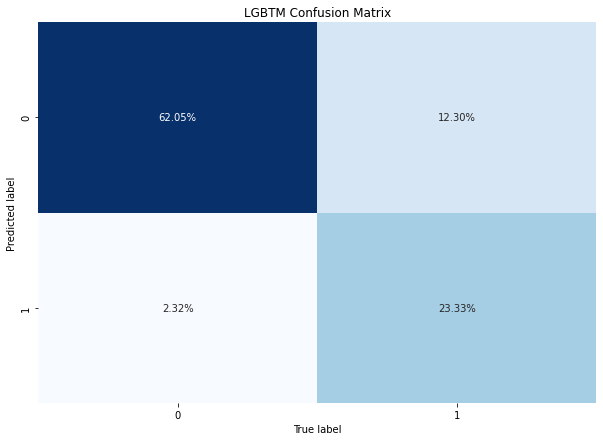

In [37]:
conf_matrix = confusion_matrix(y_val_arri, y_predi)

def plot_conf_mat(y_val, y_pred):
  fig, ax = plt.subplots(figsize=(10,7))
  ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, cbar=False, fmt='.2%', cmap='Blues')
  plt.title("LGBTM Confusion Matrix")
  plt.xlabel("True label")
  plt.ylabel("Predicted label")

plot_conf_mat(y_val, y_predi)

In [38]:
#model = Sequential()
#model.add(Dense(100, activation='relu', input_shape=input_shape))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model.summary()

In [39]:
#hist = model.fit(X_train_tr, y_train, epochs=5, batch_size=5, validation_data=(X_val_tr, y_val))

In [40]:
del X_train_tr, y_train, X_val_tr, y_val
gc.collect()

2766

In [41]:
%%time
test_df = pd.read_feather("../input/amex-default-prediction-feather/test.feather")
test_df = test_df.drop(columns = missing_value_80)
test_df.shape

CPU times: user 29.7 s, sys: 22 s, total: 51.7 s
Wall time: 46.8 s


(11363762, 166)

In [42]:
%%time
# Calculates the amount of information by costumer or records available...
tst_num_statements = test_df.groupby('customer_ID').size().sort_index()

CPU times: user 2.78 s, sys: 770 ms, total: 3.55 s
Wall time: 2.99 s


In [43]:
%%time
# Create a new dataset based on aggregated information
tst_agg_data = (test_df
                .groupby('customer_ID')
                .tail(1)
                .set_index('customer_ID', drop=True)
                .sort_index()
                )

# Merge the labels from the labels dataframe
tst_agg_data['num_statements'] = tst_num_statements

tst_agg_data.reset_index(inplace = True, drop = True) # forget the customer_IDs

CPU times: user 4.41 s, sys: 956 ms, total: 5.37 s
Wall time: 5.37 s


In [44]:
del test_df
gc.collect()

23

In [45]:
tst_agg_data['S_2'] = pd.to_datetime(tst_agg_data['S_2'])
tst_agg_data['day'] = tst_agg_data['S_2'].dt.day
tst_agg_data['month'] = tst_agg_data['S_2'].dt.month
tst_agg_data['year'] = tst_agg_data['S_2'].dt.year

In [46]:
tst_agg_data= tst_agg_data.drop(columns = ['S_2'])

In [47]:
X_test_tr = pipeline.fit_transform(tst_agg_data)

In [48]:
%%time
X_test_tr = sel_.transform(X_test_tr)

CPU times: user 159 ms, sys: 73.8 ms, total: 233 ms
Wall time: 233 ms


In [49]:
prediction = best_model.predict_proba(X_test_tr)[:,1]
#prediction = prediction.astype(int)
tst_agg_data['target'] = prediction.tolist()
prediction

array([0.85563522, 0.08810014, 0.29457586, ..., 0.95330321, 0.73149739,
       0.33175842])

In [50]:
tst_agg_data.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_144,D_145,num_statements,day,month,year,target
0,0.56885,0.12140,0.01078,1.00977,0.00692,0.14941,0.00040,...,0.00369,0.00322,9,12,10,2019,0.85564
1,0.84131,0.12646,0.01656,1.00879,0.00971,0.11218,0.00619,...,0.00025,0.00778,13,15,4,2019,0.08810
2,0.69775,0.00272,0.00148,0.81006,0.00262,0.16614,0.00489,...,0.45776,0.09204,13,16,10,2019,0.29458
3,0.51318,0.32471,0.14954,0.20569,0.00228,0.18115,0.00581,...,0.50098,0.18298,13,22,4,2019,0.81407
4,0.25439,0.76807,0.56348,0.03802,0.50293,0.16833,0.00948,...,0.00156,0.00052,13,22,10,2019,0.88009


In [51]:
sample_submission = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")
sample_submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0


In [52]:
sample_submission['prediction'] = tst_agg_data['target']
sample_submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.85564
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.08810
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.29458
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.81407
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.88009


In [53]:
sample_csv = sample_submission.to_csv('sample_submission.csv', index=False)

In [54]:
sample_df = pd.read_csv('./sample_submission.csv')
sample_df.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.85564
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.08810
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.29458
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.81407
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.88009
